In [6]:
from scipy import stats
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


In [2]:
# Supplementary figure 1:

#Reading files:
chrs=["594", "594_2", "597", "600", "601", "603", "606", "609", "610"]

def get_snpeff_vals(chr, idx):

    df=pd.read_csv(f"snpeff_results/{chr}.csv", header=None)
    df_inv=pd.read_csv(f"snpeff_results/{chr}_inv.csv", header=None)

    total_snps = int(df.iloc[0][0])
    inversion_snps = int(df_inv.iloc[0][0])
    total_outside = total_snps - inversion_snps

    total_intergenic = int(df.iloc[-1][0])
    inversion_intergenic = int(df_inv.iloc[-1][0])
    outside_intergenic = total_intergenic - inversion_intergenic

    total_outside = total_outside - outside_intergenic
    inversion_snps = inversion_snps - inversion_intergenic

    values_total = np.array(df.iloc[1:7][0].tolist()).astype(int)
    values_inverted = np.array(df_inv.iloc[1:7][0].tolist()).astype(int)
    values_outside = values_total - values_inverted

    value_labels = ["high_impact", "low_impact", "moderate_impact"] #"missense", "nonsense", "silent"]

    expected_values = []
    observed_values = []
    ps=[]
    for i in range(len(value_labels)):
        prob = (values_outside[i])/total_outside #probability of high impact in the background
        n = inversion_snps #number of coins I flipped, each SNP in inversion could be high impact
        k = values_inverted[i] #successfully finding high impact

        if k >= n:
            print("less SNP - intergenic than impact of interest number of SNPs!")
            print(chr)
            #NOTE num SNPs per impact level don't add up to total number of SNPs, > than that
            k = n

        expected_values.append(n*prob)
        observed_values.append(k)

        result=stats.binomtest(k, n, prob, alternative='two-sided') # less means what are the chances that k is less than n * p
        ps.append(result.pvalue)

        #print("----------------------")

    data = {'Inv': str(idx), 'Ratio': df_inv.iloc[-2][0], 'High_p': ps[0], 'High_exp': expected_values[0], 'High_obs': observed_values[0], 'Low_p': ps[1], 'Low_exp': expected_values[1], 'Low_obs': observed_values[1], 'Moderate_p': ps[2],	'Moderate_exp': expected_values[2], 'Moderate_obs': observed_values[2]}

    return data

all_data=[]
for i, c in enumerate(chrs):
    data = get_snpeff_vals(c, i)
    all_data.append(data)

df = pd.DataFrame(all_data)


#Preparing data:

df["H_ratio"]=df["High_obs"] / df["High_exp"]
df["M_ratio"]=df["Moderate_obs"] / df["Moderate_exp"]
df["L_ratio"]=df["Low_obs"] / df["Low_exp"]

rdf=df[["H_ratio", "M_ratio","L_ratio"]]
rdf = rdf.astype(float)
pdf=df[["High_p", "Moderate_p", "Low_p"]]
pdf = pdf.astype(float)


less SNP - intergenic than impact of interest number of SNPs!
597


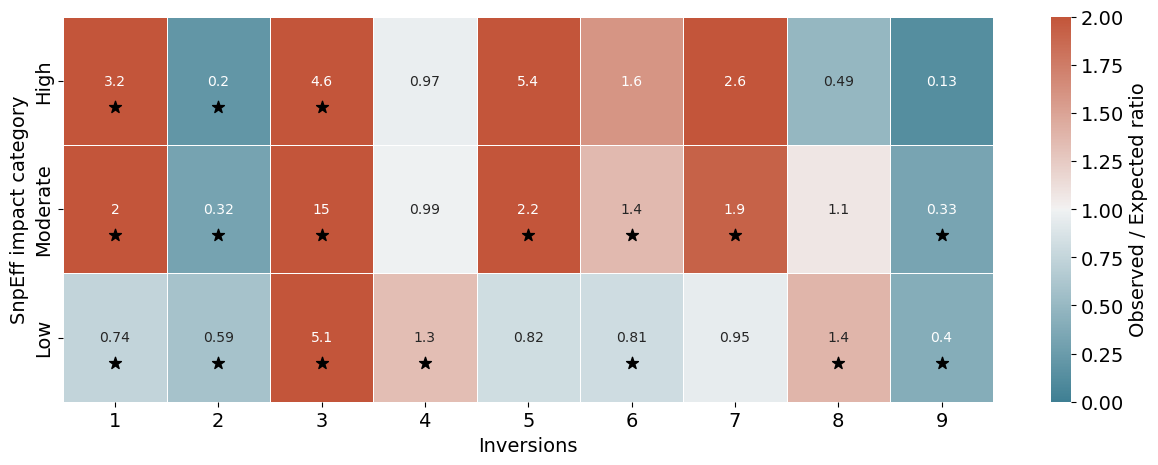

In [3]:
#Plotting:

plt.figure(figsize=(15, 5))
sns.heatmap(rdf.T, cmap=sns.diverging_palette(220, 20, as_cmap=True), center = 1, linewidths=0.5, cbar=True, vmin=0, vmax=2, annot=True)

for i in range(pdf.T.shape[1]):  # Columns in original DataFrame (now rows in heatmap)
    for j in range(pdf.T.shape[0]):  # Rows in original DataFrame (now columns in heatmap)
        if pdf.T.iloc[j, i] < 0.05/(9*3): #multiple testing correction
            plt.scatter(i +0.5, j+0.7, color='black', s=80, marker="*")

# Labels and formatting
plt.xlabel("Inversions", fontsize=14)
plt.ylabel("SnpEff impact category", fontsize=14)

new_x_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
plt.xticks(ticks=np.arange(len(new_x_labels)) + 0.5, labels=new_x_labels)

new_y_labels = ["High", "Moderate", "Low"]
plt.yticks(ticks=np.arange(len(new_y_labels)) + 0.5, labels=new_y_labels)

plt.gcf().axes[-1].set_ylabel("Observed / Expected ratio", fontsize=14)
plt.gcf().axes[-1].tick_params(labelsize=14) 

plt.tick_params(axis='both', which='major', labelsize=14)

# Save the figure as a PDF
plt.savefig("figs/snpeff_table_corr.pdf", format="pdf", bbox_inches="tight")

#plt.show()

In [4]:
# Supplementary figure 2:

#Reading and processing data:

def get_miss_sil(chr, idx):
    df_inv=pd.read_csv(f"snpeff_results/{chr}_inv.csv", header=None)
    values_inverted = np.array(df_inv.iloc[1:7][0].tolist()).astype(int)
    
    value_labels = ["high_impact", "low_impact", "moderate_impact", "missense", "nonsense", "silent"]

    for i in range(len(value_labels)):

        if value_labels[i] == "missense":
            m = values_inverted[i]
        if value_labels[i] == "silent":
            if idx == 7:
                s=1_396 #forgot to fix the html reading here
            else:
                s = values_inverted[i]

    data = {'Inv': str(idx+1), 'Missense': m, 'Silent': s} #'Ratio': df_inv.iloc[-2][0]

    return data

all_data=[]
for i, c in enumerate(chrs):
    data = get_miss_sil(c, i)
    all_data.append(data)

df = pd.DataFrame(all_data)

df["sum"]=df["Missense"] + df["Silent"] 
df["m"]=df["Missense"]/df["sum"]
df["s"]=df["Silent"]/df["sum"]
        

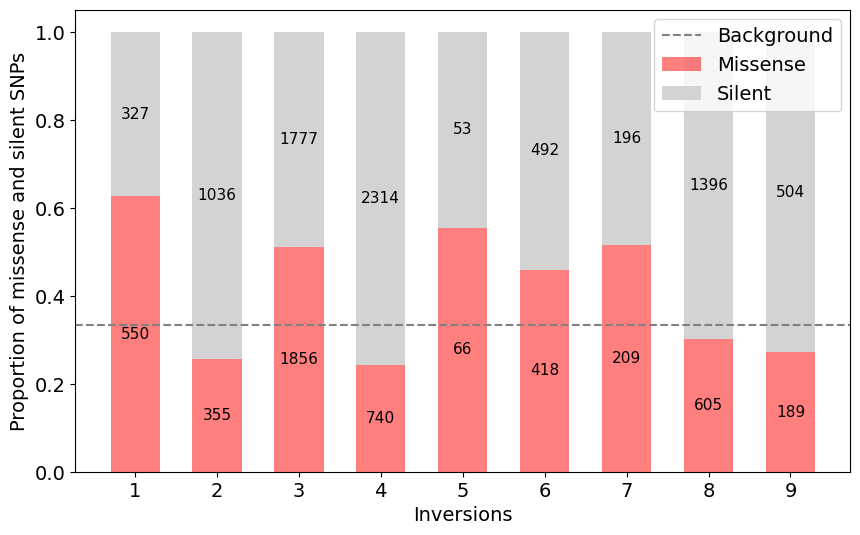

In [5]:
#Plotting:

bar_width = 0.6  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(df['Inv'], df['m'], label='Missense', width=bar_width, color="red", alpha=0.5)
bars2 = ax.bar(df['Inv'], df['s'], label='Silent', width=bar_width, bottom=df['m'], color="lightgrey")

for bar, label in zip(bars1, df['Missense']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, label, ha='center', va='center', color='black', fontsize=11)

for bar, value, label in zip(bars2, df['m'], df['Silent']):
    ax.text(bar.get_x() + bar.get_width() / 2, value + bar.get_height() / 2, label, ha='center', va='center', color='black', fontsize=11)

#Expected
line = ax.axhline(y=0.3333, color='grey', linestyle='dashed', linewidth=1.5, label='Background')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Proportion of missense and silent SNPs", fontsize=14)
ax.set_xlabel("Inversions", fontsize=14)

ax.legend(loc='upper right', fontsize=14)

plt.savefig("figs/missense_silent.pdf", format="pdf", bbox_inches="tight")


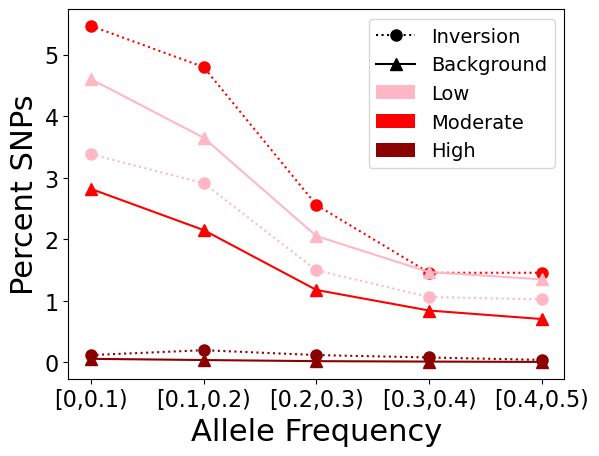

In [8]:
# Subplot from Figure 3.

#Read data

def get_counts(level, mytype,cname):

    file_path = os.path.expanduser(f'snpeff_results/{level}_{cname}_snpeff_freq.txt.frq')
    df1 = pd.read_csv(file_path, delimiter='\t')  # Use delimiter='\t' if the file is tab-separated
    df1[['ref', 'AF1']] = df1['N_CHR'].str.split(':', expand=True)
    df1[['alt', 'AF2']] = df1['{ALLELE:FREQ}'].str.split(':', expand=True)
    df1['MAF'] = df1[['AF1', 'AF2']].min(axis=1)
    df1['MAF'] = df1['MAF'].astype(float)

    file_path = os.path.expanduser(f'snpeff_results/{level}_{cname}_inv_snpeff_freq.txt.frq')
    df2 = pd.read_csv(file_path, delimiter='\t')
    df2[['ref', 'AF1']] = df2['N_CHR'].str.split(':', expand=True)
    df2[['alt', 'AF2']] = df2['{ALLELE:FREQ}'].str.split(':', expand=True)
    df2['MAF'] = df2[['AF1', 'AF2']].min(axis=1)
    df2['MAF'] = df2['MAF'].astype(float)

    #take out inversion from background
    df_diff = df1.merge(df2, how='left', indicator=True)
    df1 = df_diff[df_diff['_merge'] == 'left_only'].drop(columns=['_merge'])

    counts = []
    if mytype == "all":
        counts.append(len(df1[df1["MAF"]<0.1]))
        counts.append(len(df1[(df1["MAF"]<0.2) & (df1["MAF"]>=0.1)]))
        counts.append(len(df1[(df1["MAF"]<0.3) & (df1["MAF"]>=0.2)]))
        counts.append(len(df1[(df1["MAF"]<0.4) & (df1["MAF"]>=0.3)]))
        counts.append(len(df1[(df1["MAF"]<0.5) & (df1["MAF"]>=0.4)]))
    else:
        counts.append(len(df2[df2["MAF"]<0.1]))
        counts.append(len(df2[(df2["MAF"]<0.2) & (df2["MAF"]>=0.1)]))
        counts.append(len(df2[(df2["MAF"]<0.3) & (df2["MAF"]>=0.2)]))
        counts.append(len(df2[(df2["MAF"]<0.4) & (df2["MAF"]>=0.3)]))
        counts.append(len(df2[(df2["MAF"]<0.5) & (df2["MAF"]>=0.4)]))

    return counts, df1, df2

cname="594"
high_inv, _, _ = get_counts("high", "inv",cname)
medium_inv, _, _ = get_counts("mod", "inv",cname)
low_inv, _, _ = get_counts("low", "inv",cname)
high_out, _, _ = get_counts("high", "all",cname)
medium_out, _, _ = get_counts("mod", "all",cname)
low_out, _, _ = get_counts("low", "all",cname)

value_labels = ["[0,0.1)","[0.1,0.2)","[0.2,0.3)","[0.3,0.4)","[0.4,0.5)"]

df=pd.read_csv(f"snpeff_results/{cname}.csv", header=None)
df_inv=pd.read_csv(f"snpeff_results/{cname}_inv.csv", header=None)

total_snps = int(df.iloc[0][0])
inversion_snps = int(df_inv.iloc[0][0])
total_outside = total_snps - inversion_snps

total_intergenic = int(df.iloc[-1][0])
inversion_intergenic = int(df_inv.iloc[-1][0])
outside_intergenic = total_intergenic - inversion_intergenic

total_outside = total_outside - outside_intergenic
inversion_snps = inversion_snps - inversion_intergenic

values_total = np.array(df.iloc[1:7][0].tolist()).astype(int)
values_inverted = np.array(df_inv.iloc[1:7][0].tolist()).astype(int)
values_outside = values_total - values_inverted

m=8
mcs=["#8B0000","#FF0000","#Ffb7c5"] #  Ffb7c5
alphas=[]
plt.plot(list(range(len(high_inv))),np.array(high_inv)/inversion_snps*100, marker="o",markersize=m, label="Inversion",linestyle=":",color=mcs[0])
plt.plot(list(range(len(high_inv))),np.array(high_out)/total_outside*100, marker="^",markersize=m, label="Background",linestyle="-",color=mcs[0])
plt.plot(list(range(len(high_inv))),np.array(medium_inv)/inversion_snps*100, marker="o",markersize=m, linestyle=":",color=mcs[1])
plt.plot(list(range(len(high_inv))),np.array(medium_out)/total_outside*100, marker="^",markersize=m,linestyle="-",color=mcs[1])
plt.plot(list(range(len(high_inv))),np.array(low_inv)/inversion_snps*100, marker="o",markersize=m,linestyle=":",color=mcs[2])
plt.plot(list(range(len(high_inv))),np.array(low_out)/total_outside*100, marker="^",markersize=m,linestyle="-",color=mcs[2])

plt.xticks(list(range(len(high_inv))), value_labels)

legend_elements = [
    mlines.Line2D([], [], color='black', linestyle=':', marker='o', markersize=m, label='Inversion'),
    mlines.Line2D([], [], color='black', linestyle='-', marker='^',markersize=m,label='Background'),
    mpatches.Patch(facecolor=mcs[2], edgecolor='None',label='Low'),
    mpatches.Patch(facecolor=mcs[1], edgecolor='None',label='Moderate'),
    mpatches.Patch(facecolor=mcs[0], edgecolor='None',label='High')
]

plt.tick_params(axis='both', which='major', labelsize=16)

plt.legend(handles=legend_elements, loc='upper right', fontsize=14)
plt.ylabel("Percent SNPs",fontsize=22)
plt.xlabel("Allele Frequency",fontsize=22)

plt.savefig("intermediary_files/inv1/inv1_snpeff_by_AF.pdf", format='pdf', bbox_inches='tight')